In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [3]:
import requests

In [4]:
ticker='SPY'
d={'function': 'TIME_SERIES_DAILY_ADJUSTED','apikey':"YEUC2DL0F7KC43PB",'symbol':ticker,'outputsize':'full'}
response = requests.get(
        'https://www.alphavantage.co/query',
        params=d,
        )

In [5]:
#open #high #low #close #adjusted close  #volume #dividend amount
spy=[[],[],[],[],[],[],[]]
for key, val in response.json()['Time Series (Daily)'].items():
    spy[0].append(float(val['1. open']))
    spy[1].append(float(val['2. high']))
    spy[2].append(float(val['3. low']))
    spy[3].append(float(val['4. close']))
    spy[4].append(float(val['5. adjusted close']))
    spy[5].append(float(val['6. volume']))
    spy[6].append(float(val['7. dividend amount']))

In [6]:
spy=pd.DataFrame({'Date':list(response.json()['Time Series (Daily)'].keys()),
                 'open':spy[0],
                  'high':spy[1],
                  'low':spy[2],
                  'close':spy[3],
                  'adj_close':spy[4],
                  'volume':spy[5],
                  'dividend':spy[6],
                 })
spy=spy.astype({'Date': 'datetime64'})


spy=spy.sort_values(by='Date')

In [7]:
spy.head()

,Date,open,high,low,close,adj_close,volume,dividend
5032,2000-05-22,141.2500,141.4687,137.0000,140.0625,95.9201,10839400.0,0.0
5031,2000-05-23,140.4375,140.8125,137.5625,138.0000,94.5076,7979200.0,0.0
5030,2000-05-24,138.0000,140.6875,136.5000,140.2500,96.0485,11081500.0,0.0
5029,2000-05-25,140.6875,141.8125,137.7187,137.8437,94.4006,8278900.0,0.0
5028,2000-05-26,138.8125,139.6875,137.3281,138.0000,94.5076,4814000.0,0.0


In [7]:
spy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5033 entries, 5032 to 0
Data columns (total 8 columns):
Date         5033 non-null datetime64[ns]
open         5033 non-null float64
high         5033 non-null float64
low          5033 non-null float64
close        5033 non-null float64
adj_close    5033 non-null float64
volume       5033 non-null float64
dividend     5033 non-null float64
dtypes: datetime64[ns](1), float64(7)
memory usage: 353.9 KB


In [8]:
spy=spy.astype({'Date': 'datetime64'})

In [9]:
dspy=spy.copy(deep=True)
dspy.set_index('Date', inplace=True)

In [10]:
spy.describe().T

,count,mean,std,min,25%,50%,75%,max
open,5033.0,70.332577,38.041941,21.840,45.8100,54.4700,85.840,1.931400e+02
high,5033.0,70.849357,38.244619,22.880,46.0886,54.9000,86.720,1.944400e+02
low,5033.0,69.836907,37.828935,21.500,45.4800,54.0800,85.410,1.924480e+02
close,5033.0,70.378629,38.045700,22.310,45.8000,54.5300,86.100,1.943000e+02
adj_close,5033.0,21.693550,18.452922,1.737,4.2514,13.6238,40.197,6.514000e+01
volume,5033.0,647656.845619,998751.193107,1080.000,34500.0000,207481.0000,981735.000,1.196873e+07
dividend,5033.0,0.003482,0.060227,0.000,0.0000,0.0000,0.000,2.264300e+00


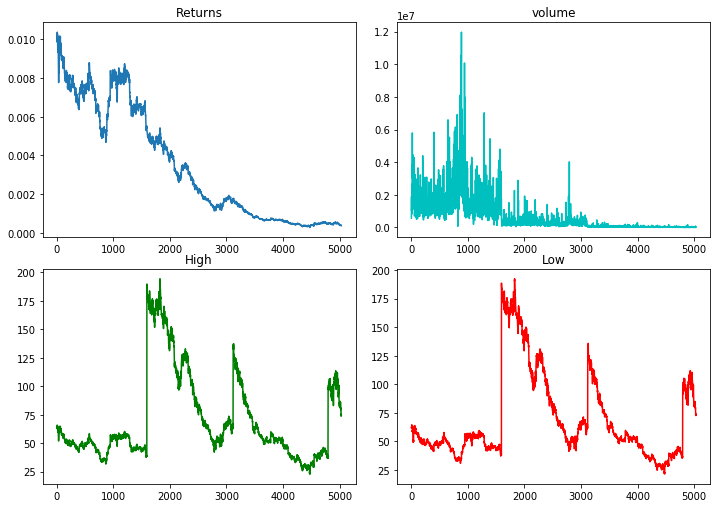

In [11]:
fig, ax = plt.subplots(2,2, figsize=(10,7))
fig.tight_layout()
ax[0][1].plot(spy.volume, color='c')
ax[0][1].set_title("volume");

ax[0][0].plot(spy.adj_close/spy.adj_close[0]/100);
ax[0][0].set_title("Returns");

ax[1][1].plot(spy.low, color='r')
ax[1][1].set_title("Low");

ax[1][0].plot(spy.high, color='g')
ax[1][0].set_title("High");

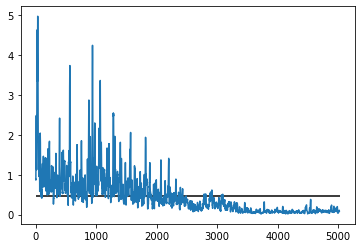

In [12]:
plt.plot(spy.adj_close.rolling(14).std())
np.mean(spy.adj_close.rolling(14).std())
plt.hlines(np.mean(spy.adj_close.rolling(14).std()),0,len(spy))

In [13]:
spy['std']=spy.adj_close.rolling(14).std()

In [14]:
def std_dev_percentile(x,window):
    x=x.rolling(window).std().dropna().values
    #print(x)
    val=x[-1:]
    return np.round(100*(np.where(np.sort(x)==val)[0][0]/len(x)),2),val


In [15]:
std_dev_percentile(spy.adj_close[-500:],10)

(68.02, array([0.99738324]))

In [16]:
def return_percentile_latest(x,window):
    x=x/x.shift(window)-1
    x=x.dropna().values
    val=x[-1]
    return np.round(100*(np.where(np.sort(x)==val)[0][0]/len(x)),2),val

def return_percentile(x,window,val):
    x=x/x.shift(window)-1
    x=x.dropna()
    return np.percentile(x,val)

def get_percentile(x, t='latest',val=0):
    if t=='latest':
        x=x.dropna().values
        val=x[-1]
        return np.round(100*(np.where(np.sort(x)==val)[0][0]/len(x)),2),val
    else:
        return  np.percentile(np.sort(x),val)
        

In [17]:
return_percentile_latest(spy.adj_close,3)#returns percentile and latest value, shift doesn't include current pos
#return_percentile(spy.adj_close,3,1.6)

(25.65, -0.01273184533165661)

### RSI

In [18]:
def RSI(series, period=14):
 print(len(series))
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 #rs = pd.stats.moments.ewma(u, com=period-1, adjust=False) / pd.stats.moments.ewma(d, com=period-1, adjust=False)
 rs = pd.Series.ewm(u, com=period-1).mean()/pd.Series.ewm(d, com=period-1).mean()
 return 100 - 100 / (1 + rs)

In [19]:
#spy.Close.rolling(14).apply(RSI, raw=False)
#Graph
#min max, %s 
#fit 14 vs 10
#backtested profitability


In [20]:
rsi=RSI(spy.adj_close).dropna();

5033


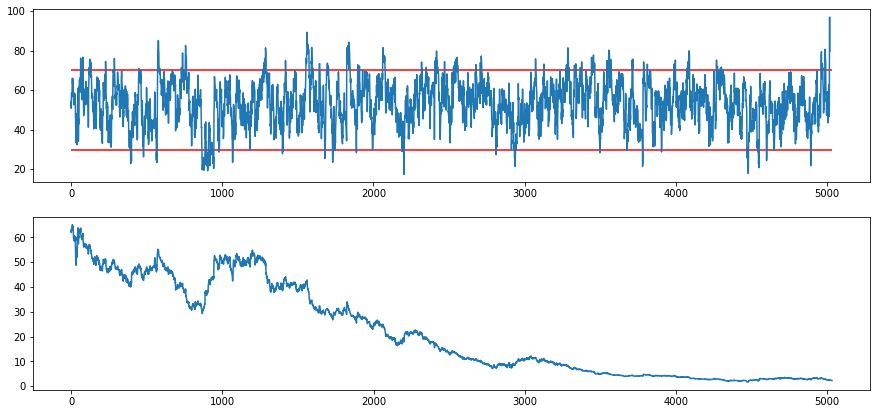

In [21]:
fig, ax= plt.subplots(2,1, figsize=(15,7))
ax[0].plot(rsi)
ax[0].hlines(70,0,len(spy), color='red')
ax[0].hlines(30,0,len(spy), color='red')
ax[1].plot(spy.adj_close);

In [22]:
print("Min RSI", np.min(rsi))
print("Max RSI", np.max(rsi))
print("Median RSI", np.median(rsi))
print("Std dev. RSI", np.std(rsi))
print("% of time below 20", np.round(100*np.sum(np.where(rsi<20,1,0))/len(rsi),2))
print("% of time below 30", np.round(100*np.sum(np.where(rsi<30,1,0))/len(rsi),2))
print("% of time above 70", np.round(100*np.sum(np.where(rsi>70,1,0))/len(rsi),2))
print("% of time above 80", np.round(100*np.sum(np.where(rsi>80,1,0))/len(rsi),2))

Min RSI 17.426268095170457
Max RSI 96.91690795489178
Median RSI 54.03597357729543
Std dev. RSI 11.295876519993817
% of time below 20 0.1
% of time below 30 2.75
% of time above 70 6.08
% of time above 80 0.66


In [23]:
rsi.describe()

count    5019.000000
mean       53.409041
std        11.297002
min        17.426268
25%        45.741947
50%        54.035974
75%        61.017626
max        96.916908
Name: adj_close, dtype: float64

In [24]:
get_percentile(rsi)

(50.77, 54.243578130443716)

### MACD

In [25]:
macd=spy.adj_close.ewm(span=12,min_periods=0,adjust=True,ignore_na=True).mean()-spy.adj_close.ewm(span=26,min_periods=0,adjust=True,ignore_na=True).mean()

In [26]:
signal=macd.ewm(span=12,min_periods=0,adjust=True,ignore_na=True).mean()
macd_hist=macd-signal

In [27]:
macd_hist.describe()

count    5033.000000
mean        0.001507
std         0.185321
min        -1.348867
25%        -0.042266
50%         0.001626
75%         0.048732
max         1.222017
Name: adj_close, dtype: float64

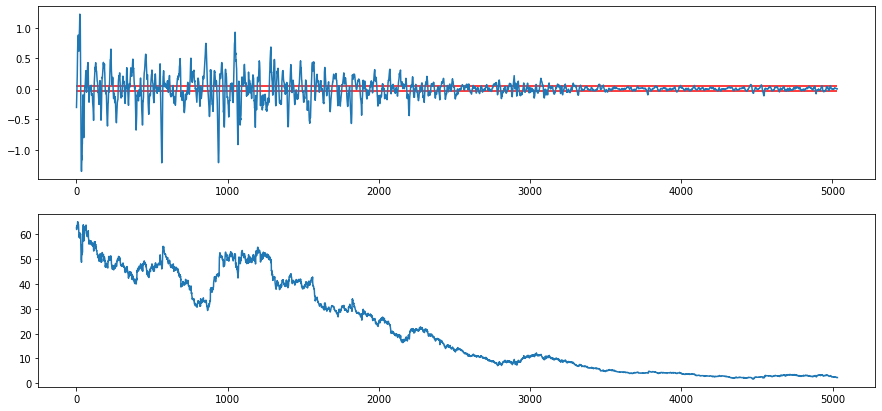

In [28]:
fig, ax= plt.subplots(2,1, figsize=(15,7))
ax[0].plot(macd_hist)
ax[0].hlines(np.percentile(macd_hist,75),0,len(spy), color='red')
ax[0].hlines(np.percentile(macd_hist,25),0,len(spy), color='red')
ax[1].plot(spy.adj_close);

In [29]:
spy['macd']=macd
spy['macd_hist']=macd_hist

In [30]:
dspy['macd']=macd
dspy['macd_hist']=macd_hist

In [31]:
def calcs(x):
    print(x)
    return 0

In [32]:
spy.macd[0]=-1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [33]:
results=pd.DataFrame(columns=['start_date','end_date','entry_price','exit_price','is_long'])

In [34]:
def sign_change(x):
    if np.sign(x[0]) == np.sign(x[1]):
        return False
    return True

In [35]:
#On sign change.
has_position=False
position_start_index=-1
position_end_index=-1
last=0
is_long=False
for index, row in spy.iterrows():
    if  index == 0:
        last=row.macd
        continue
    if sign_change([last,row.macd]):
        #print(index)
        if has_position:
            #has_position=False #Uncommented for long only
            #print(last, row.macd, index)
            results=results.append({'start_date':spy.loc[position_start_index,'Date'],'end_date':spy.loc[index,'Date'],'entry_price':spy.loc[position_start_index,'adj_close'],'exit_price':spy.loc[index,'adj_close'],'is_long':is_long}, ignore_index=True)
            if has_position:
                position_start_index=index
                if row.macd>0:
                    is_long=True
                else:
                    is_long=False
        
        else:
            has_position=True
            position_start_index=index
            if row.macd>0:
                is_long=True
            else:
                is_long=False
            
                           
    last=row.macd                 

In [36]:
#On sign change buy and below -x sell:
has_position=False
position_start_index=-1
position_end_index=-1
last=0
is_long=False
for index, row in spy.iterrows():
    if  index == 0:
        last=row.macd
        continue
    if has_position and row.macd<=-0.2:
        #print(index)
        #if has_position:
            has_position=False #Uncommented for long only
            #print(last, row.macd, index)
            results=results.append({'start_date':spy.loc[position_start_index,'Date'],'end_date':spy.loc[index,'Date'],'entry_price':spy.loc[position_start_index,'adj_close'],'exit_price':spy.loc[index,'adj_close'],'is_long':is_long}, ignore_index=True)
            
    elif last<0 and row.macd>=0:
            has_position=True
            position_start_index=index
            if row.macd>0:
                is_long=True
            else:
                is_long=False
            
                           
    last=row.macd                 

In [37]:
def calc_returns(x):
    if x.is_long==True:
        return np.round(100*(x.exit_price/x.entry_price-1),2)
    return -1*np.round(100*(x.exit_price/x.entry_price-1),2)

In [38]:
#results['returns']=np.round(100*(results.exit_price/results.entry_price-1),2)
results['returns']=results.apply(calc_returns, axis=1)

In [39]:
#results.sort_values(by='returns', ascending=False)
results

,start_date,end_date,entry_price,exit_price,is_long,returns
0,2000-05-08,2000-05-12,2.2804,2.3361,False,-2.44
1,2000-05-12,2000-09-11,2.3361,2.9874,True,27.88
2,2000-09-11,2000-09-25,2.9874,3.3965,False,-13.69
3,2000-09-25,2000-11-03,3.3965,3.1260,True,-7.96
4,2000-11-03,2001-01-26,3.1260,2.9625,False,5.23
...,...,...,...,...,...,...
200,2018-07-06,2018-08-13,46.6104,45.5417,True,-2.29
201,2018-08-27,2018-09-18,47.9391,45.6668,True,-4.74
202,2018-12-27,2019-04-18,43.8952,47.3159,True,7.79
203,2019-06-07,2019-07-15,48.2351,46.5923,True,-3.41


In [40]:
results.returns.describe()

count    205.000000
mean      -0.684293
std        9.667637
min      -17.600000
25%       -5.420000
50%       -3.070000
75%       -0.500000
max       42.180000
Name: returns, dtype: float64

In [41]:
value_trend=[1000]
for r in results.returns:
    value_trend.append(value_trend[-1]*(1+r/100))

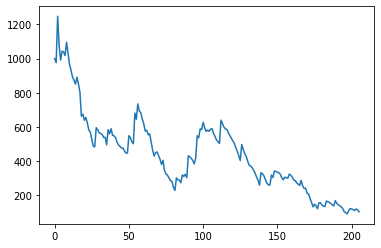

In [42]:
plt.plot(value_trend)

In [43]:
print(f'Returns (%) :', np.round(100*(value_trend[-1]/value_trend[0]-1)))
print(f'SPY returns (%) :', np.round(100*(spy.adj_close[-1:]/spy.adj_close[0]-1)))

Returns (%) : -90.0
SPY returns (%) : 0    0.0
Name: adj_close, dtype: float64


In [44]:
macd_pos=spy.macd[spy.macd>=0]
macd_pos.describe()

count    3237.000000
mean        0.286031
std         0.349841
min         0.000000
25%         0.051136
50%         0.141696
75%         0.399007
max         2.207460
Name: macd, dtype: float64

In [45]:
macd_neg=spy.macd[spy.macd<=0]
macd_neg.describe()

count    1797.000000
mean       -0.287946
std         0.413095
min        -2.877554
25%        -0.361499
50%        -0.124729
75%        -0.038583
max         0.000000
Name: macd, dtype: float64

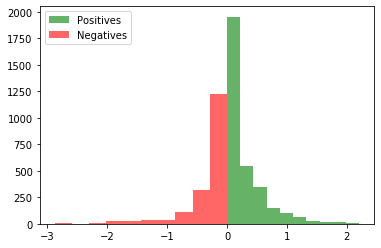

In [46]:
plt.hist(macd_pos, bins=10, alpha=0.6, color='g' ,label='Positives')
plt.hist(macd_neg, bins=10, alpha=0.6, color='r' ,label='Negatives')
plt.legend(loc='upper left');

In [47]:
get_percentile(macd_neg,t='val',val=10)

-0.707275690832924

In [48]:
get_percentile(macd_neg)

(6.51, -1.0)

In [49]:
# macd turning point
#slopes
#value at stage of cycle
# cycle leegth vs depth 

In [50]:
macd_results=pd.DataFrame(columns=['start_date','end_date','is_long','hist','length'])

In [51]:
#### MACD values per cycle
w_macd=[]
cycle_macd_hist=[]
counter=1
has_position=False
position_start_index=-1
position_end_index=-1
last=0
is_long=False
for index, row in spy.iterrows():
    if  index == 0:
        last=-1#row[index+1].macd_hist
        continue
    if sign_change([last,row.macd_hist]):
        #print(index)
        if has_position:
            #has_position=False #Uncommented for long only
            #print(last, row.macd, index)
            macd_results=macd_results.append({'start_date':spy.loc[position_start_index,'Date'],'end_date':spy.loc[index,'Date'],'is_long':is_long,'hist':cycle_macd_hist,'length':counter-1}, ignore_index=True)
            counter=1
            if has_position:
                position_start_index=index
                cycle_macd_hist=[]
                cycle_macd_hist.append(row.macd_hist)
                w_macd.append(counter*row.macd_hist)
                counter+=1
                if row.macd_hist>0:
                    is_long=True
                else:
                    is_long=False
                    
        
        else:
            has_position=True
            position_start_index=index
            w_macd.append(counter*row.macd_hist)
            counter+=1
            cycle_macd_hist.append(row.macd_hist)
            if row.macd_hist>0:
                is_long=True
            else:
                is_long=False
            
    elif has_position:
        cycle_macd_hist.append(row.macd_hist)
        w_macd.append(counter*row.macd_hist)
        counter+=1
    last=row.macd_hist                 

In [52]:
macd_results

,start_date,end_date,is_long,hist,length
0,2000-05-08,2000-05-12,False,"[-9.871794871800048e-05, -6.027321081088666e-0...",4
1,2000-05-12,2000-06-08,True,"[0.0015992407278475043, 0.004368524486394938, ...",18
2,2000-06-08,2000-06-20,False,"[-0.0009328382887743292, -0.003185863519244356...",8
3,2000-06-20,2000-06-26,True,"[0.0032348536232679644, 0.002917174640802399, ...",4
4,2000-06-26,2000-07-03,False,"[-0.003857493207277421, -0.0017018515728241812...",5
...,...,...,...,...,...
375,2020-01-14,2020-01-30,True,"[0.09287550408407347, 0.3355883442150824, 0.40...",11
376,2020-01-30,2020-02-05,False,"[-0.008781225106992419, -0.037049090513740945,...",4
377,2020-02-05,2020-02-20,True,"[0.16696414758065947, 0.2987524934292439, 0.26...",10
378,2020-02-20,2020-03-27,False,"[-0.011546889056430087, -0.03580407306851918, ...",26


In [53]:
w_macd=np.asarray(w_macd)
w_macd[-1:]

array([-0.50491328])

In [54]:
np.percentile(w_macd[w_macd<=0],0.5)

-15.77999611588382

### STO

In [8]:
d={'function': 'STOCH','apikey':"YEUC2DL0F7KC43PB",'symbol':ticker,'interval':'daily','fastkperiod':22 }
response = requests.get(
        'https://www.alphavantage.co/query',
        params=d,
        )

#https://www.alphavantage.co/query?function=STOCH&symbol=SPY&interval=weekly&apikey=YEUC2DL0F7KC43PB&fastkperiod=16

In [9]:
slowk=[]
slowd=[]
for key, val in response.json()['Technical Analysis: STOCH'].items():
    slowk.append(float(val['SlowK']))
    slowd.append(float(val['SlowD']))

In [10]:
sto=pd.DataFrame({'Date':list(response.json()['Technical Analysis: STOCH'].keys()),
                 'k':slowk,
                  'd':slowd
                 })

In [11]:
sto=sto.astype({'Date': 'datetime64'})

In [12]:
spy=spy.merge(sto,left_on='Date',right_on='Date',how='left')

In [13]:
spy['sto_diff']=spy['k']-spy['d']

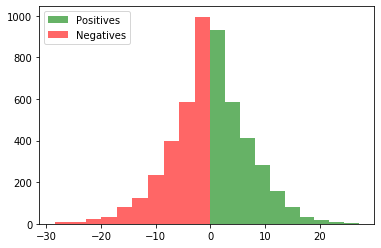

In [14]:
plt.hist(spy.sto_diff[spy.sto_diff>=0], bins=10, alpha=0.6, color='g' ,label='Positives')
plt.hist(spy.sto_diff[spy.sto_diff<=0], bins=10, alpha=0.6, color='r' ,label='Negatives')
plt.legend(loc='upper left');

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


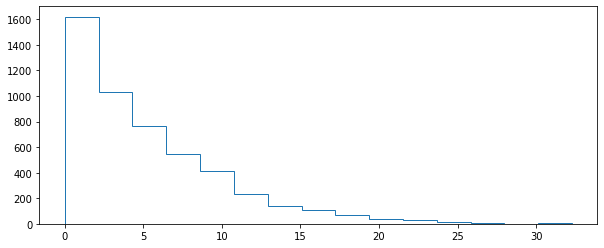

In [62]:
plt.figure(figsize=(10,4))
plt.hist(np.abs(spy.sto_diff), bins=15, histtype='step');

In [63]:
get_percentile(np.abs(spy.sto_diff.dropna()),t='val',val=10)

0.5805800000000033

In [64]:
get_percentile(spy.sto_diff.dropna(),t='val',val=12)

-7.991688000000006

In [65]:
get_percentile(spy.sto_diff[spy.sto_diff>=0].dropna(),t='val',val=99)

21.06455200000002

In [66]:
get_percentile(spy.sto_diff)

(20.05, -5.0565)

In [15]:
spy.dropna().head(5)

,Date,open,high,low,close,adj_close,volume,dividend,k,d,sto_diff
25,2000-06-27,145.9843,146.7187,145.0156,145.1562,99.6447,4159500.0,0.0,67.9005,70.8354,-2.9349
26,2000-06-28,145.6250,146.9843,145.3125,145.5625,99.9236,5347700.0,0.0,68.1276,68.6337,-0.5061
27,2000-06-29,144.7500,145.7500,143.5156,144.1875,98.9797,6345700.0,0.0,52.9109,62.9797,-10.0688
28,2000-06-30,143.9375,145.5937,143.8906,145.2812,99.7305,7420200.0,0.0,43.2019,54.7468,-11.5449
29,2000-07-03,145.4375,147.4375,145.1875,147.2812,101.1034,1436600.0,0.0,44.4870,46.8666,-2.3796


In [68]:
results=pd.DataFrame(columns=['start_date','end_date','entry_price','exit_price','is_long'])

In [69]:
#On sign change.
has_position=False
position_start_index=-1
position_end_index=-1
last=0
is_long=False
for index, row in spy.dropna().iterrows():
    if  index == 1847:
        last=row.sto_diff
        continue
    if sign_change([last,row.sto_diff]):
        #print(index)
        if has_position:
            #has_position=False 
            #print(last, row.macd, index)
            results=results.append({'start_date':spy.loc[position_start_index,'Date'],'end_date':spy.loc[index,'Date'],'entry_price':spy.loc[position_start_index,'adj_close'],'exit_price':spy.loc[index,'adj_close'],'is_long':is_long}, ignore_index=True)
            if has_position:
                position_start_index=index
                if row.sto_diff>0:
                    is_long=True
                else:
                    is_long=False
        
        else:
            has_position=True
            position_start_index=index
            if row.sto_diff>0:
                is_long=True
            else:
                is_long=False
            
                           
    last=row.sto_diff

In [70]:
def close_position(x,is_long):
    if is_long and x> -6.80:
        return False
    elif ~is_long and x<0:
        return True
    return True

In [71]:
#On sign change buy and below -x sell:

has_position=False
position_start_index=-1
position_end_index=-1
last=0
is_long=False
for index, row in spy.dropna().iterrows():
    if  index == 1847:
        last=row.sto_diff
        continue
    if has_position and row.sto_diff<-6.8:#close_position(row.sto_diff,is_long):
        #print(index)
        #if has_position:
            has_position=False #Uncommented for long only
            #print(last, row.macd, index)
            results=results.append({'start_date':spy.loc[position_start_index,'Date'],'end_date':spy.loc[index,'Date'],'entry_price':spy.loc[position_start_index,'adj_close'],'exit_price':spy.loc[index,'adj_close'],'is_long':is_long}, ignore_index=True)
            if has_position:
                position_start_index=index
                if row.sto_diff>0:
                    is_long=True
                else:
                    is_long=False
            
    elif ~has_position and last<0 and row.sto_diff>=0:# and index<=1852:

            has_position=True
            position_start_index=index
            if row.sto_diff>0:
                is_long=True
            else:
                is_long=False
                         
    last=row.sto_diff
                               

In [72]:
results['returns']=results.apply(calc_returns, axis=1)

In [73]:
results#.tail(20)

,start_date,end_date,entry_price,exit_price,is_long,returns
0,2000-06-12,2000-06-19,2.4630,2.6127,False,-6.08
1,2000-06-19,2000-06-22,2.6127,2.6127,True,0.00
2,2000-06-22,2000-06-28,2.6127,2.6050,False,0.29
3,2000-06-28,2000-07-12,2.6050,3.0218,True,16.00
4,2000-07-12,2000-07-26,3.0218,2.8432,False,5.91
...,...,...,...,...,...,...
1476,2020-01-30,2020-02-11,60.0367,62.2263,True,3.65
1477,2020-02-18,2020-02-24,63.2126,60.4411,True,-4.38
1478,2020-03-02,2020-03-09,60.2833,58.6362,True,-2.73
1479,2020-03-16,2020-03-20,51.8701,48.7829,True,-5.95


In [74]:
results.returns.describe()

count    1481.000000
mean       -0.392957
std         3.464057
min       -18.890000
25%        -2.250000
50%        -0.790000
75%         0.990000
max        18.530000
Name: returns, dtype: float64

In [75]:
v=1000
value_trend=[]
for r in res:
    value_trend.append(v*(1+r/100))
    v=value_trend[-1]

NameError: name 'res' is not defined

In [ ]:
v

In [ ]:
plt.plot(value_trend)

In [16]:
spy['k_change'] = spy.k/spy.k.shift(3)-1

In [78]:
spy=spy.dropna()
#spy['mov']=spy.k_change*spy['std']

In [79]:
get_percentile(spy.k_change,'val',12)

-0.41100863048191444

In [ ]:
spy.set_index('Date')['2018-3-5':'2018-4-2']

In [34]:
spy['ret']=100*(spy.adj_close.shift(3)/spy.adj_close-1)

In [80]:
res=[]
last=0
for index, row in spy.dropna().iterrows():
    if row.k_change<=-.40:
        print(row.Date, row.k,row.k_change,row['std'])
    continue    
    
    if row.k>40 and spy.loc[last,'k']<40:
        res.append(row.ret)
        print(row.Date, row.ret)
    last=index            
        

2000-08-23 00:00:00 48.3117 -0.4042704573675624 0.13605083103889332
2000-09-07 00:00:00 21.5243 -0.43059064418760296 0.07623274512026446
2000-09-08 00:00:00 11.9445 -0.6686602439450638 0.08245387155292162
2000-09-11 00:00:00 8.0642 -0.7453590115223453 0.0900440649147592
2000-09-12 00:00:00 6.275 -0.7084690326746979 0.09949530802344927
2000-09-13 00:00:00 6.7217 -0.43725564067143874 0.1027012203400738
2000-10-16 00:00:00 36.3794 -0.44505445054450554 0.09962890153955369
2000-11-06 00:00:00 22.4359 -0.5551945090979742 0.06862695142244395
2000-11-07 00:00:00 15.3846 -0.7037851409295439 0.07282051697363669
2000-11-08 00:00:00 17.3077 -0.56402240885069 0.06805265454931798
2000-11-15 00:00:00 13.6461 -0.5049321399936875 0.08695228071119894
2000-11-16 00:00:00 7.6369 -0.7437943886982223 0.08627625066361792
2000-11-17 00:00:00 9.3233 -0.5724786544263979 0.12675096635737143
2000-11-22 00:00:00 4.9233 -0.4719359025237845 0.23121378112564495
2000-12-22 00:00:00 34.9198 -0.44914847836649185 0.11685

2004-10-27 00:00:00 16.4697 -0.5806248726828275 0.038944895559350004
2004-10-28 00:00:00 7.5974 -0.7879231125676226 0.0627694390013647
2004-10-29 00:00:00 6.0397 -0.7707110588056642 0.08529506253193073
2004-11-01 00:00:00 7.6608 -0.5348549153900799 0.103075998847838
2005-01-04 00:00:00 37.676 -0.57827670582125 0.0733054500771215
2005-01-05 00:00:00 12.5826 -0.8501109640590807 0.09973715042973756
2005-01-06 00:00:00 13.3272 -0.7993544268731858 0.10584223175083642
2005-01-19 00:00:00 11.077 -0.5468491760894111 0.10345979098985801
2005-01-20 00:00:00 2.7437 -0.9034340277411158 0.09714005437949477
2005-01-21 00:00:00 5.2304 -0.7160801428718767 0.08410531336532304
2005-03-23 00:00:00 49.4266 -0.46379179413742977 0.05615268823155944
2005-03-24 00:00:00 36.1451 -0.5593737504754288 0.0580270626520614
2005-03-28 00:00:00 19.8385 -0.721971516743233 0.06089601296990303
2005-03-29 00:00:00 13.6913 -0.7229973334196567 0.06800347114624493
2005-03-30 00:00:00 6.1075 -0.8310282721586052 0.074773686754

2009-03-02 00:00:00 6.2376 -0.7765142150803461 0.3138715917360977
2009-03-03 00:00:00 3.7589 -0.8347896027636887 0.3655478477724032
2009-03-09 00:00:00 3.7574 -0.5475574072513155 0.483925855334852
2009-03-10 00:00:00 4.8765 -0.4465440926115083 0.5153247170581041
2009-04-06 00:00:00 31.1983 -0.6136208547122867 0.34234671006180134
2009-04-07 00:00:00 18.7932 -0.7263545980325348 0.3693259824581926
2009-04-08 00:00:00 17.9935 -0.6598691535432699 0.396453881649243
2009-04-09 00:00:00 13.5951 -0.5642358718263495 0.4181524447948835
2009-04-13 00:00:00 10.7597 -0.42746844603367173 0.4452117629243171
2009-04-14 00:00:00 7.3487 -0.5915914080084475 0.48843934015495877
2009-04-15 00:00:00 5.9141 -0.5649829718060183 0.5177796326305739
2009-09-25 00:00:00 52.491 -0.4009723030572768 0.17611852589938204
2009-10-09 00:00:00 28.0543 -0.4288224347776515 0.163326602612708
2009-10-30 00:00:00 28.6026 -0.5533586407096892 0.1701012161520455
2009-11-02 00:00:00 14.3553 -0.7722382381080065 0.1897056976040441
2

2014-05-19 00:00:00 7.0447 -0.79425345432349 0.7884660018664321
2014-05-20 00:00:00 6.7061 -0.661847758123399 0.6664164018537376
2014-05-30 00:00:00 7.5469 -0.6889210400488038 0.43570215807339513
2014-06-02 00:00:00 8.3354 -0.5610359791034716 0.3262806330199279
2014-07-21 00:00:00 28.1854 -0.5523689881951601 0.38009379647817637
2014-08-04 00:00:00 39.617 -0.49106600328095884 0.372242590167195
2014-08-05 00:00:00 35.6296 -0.5578806822835105 0.367443337039036
2014-08-08 00:00:00 19.765 -0.4452646114466624 0.5854445933847182
2014-08-11 00:00:00 14.0067 -0.6637918618941547 0.6417234408690101
2014-08-12 00:00:00 10.5791 -0.6970831030720906 0.72093941222493
2014-09-08 00:00:00 36.8417 -0.5189317225340839 0.4226846873148219
2014-10-08 00:00:00 36.3676 -0.47278051609162075 0.6985140992230445
2014-10-09 00:00:00 17.8127 -0.7207712505388564 0.9684346230779006
2014-10-10 00:00:00 9.471 -0.8122089000013879 1.2785958401593376
2014-10-13 00:00:00 0.8823 -0.9757393944060098 1.527659371229644
2014-10-

2018-02-01 00:00:00 38.2003 -0.5615777567877445 1.6236648805695328
2018-02-02 00:00:00 16.9618 -0.7910634922199119 2.2240942386052507
2018-02-05 00:00:00 4.0563 -0.9348982700205916 2.8379592583944806
2018-02-06 00:00:00 3.5495 -0.907081881555904 3.24436716404973
2018-02-07 00:00:00 7.826 -0.5386102890023465 3.49320235173459
2018-03-01 00:00:00 31.5036 -0.4234798076289611 1.3369136958547583
2018-03-02 00:00:00 26.535 -0.5039472970876182 1.2920782017334707
2018-03-15 00:00:00 16.6281 -0.581526156974564 1.1005247144372015
2018-03-16 00:00:00 11.8596 -0.6623860941650037 0.590786492038354
2018-03-19 00:00:00 12.9123 -0.4941708778939946 0.3246225842373771
2018-03-23 00:00:00 3.6213 -0.7380539039104206 0.520904757065246
2018-03-26 00:00:00 6.5445 -0.476071154092481 0.5169411807882399
2018-04-17 00:00:00 37.5149 -0.4439188888724189 0.541959292750958
2018-04-18 00:00:00 31.8996 -0.40488929682777763 0.5617352106350908
2018-04-19 00:00:00 21.7332 -0.5189694669160367 0.6920243367371376
2018-04-20 

In [ ]:
plt.hist(res);

In [ ]:
pd.DataFrame(res).describe()

In [26]:
spy[spy.k_change<=-0.4].set_index('Date')['2019-7-15':'2019-10-15']

,open,high,low,close,adj_close,volume,dividend,k,d,sto_diff,k_change,ret
Date,,,,,,,,,,,,
2019-08-01,297.60,300.87,293.9600,294.84,290.2659,142646576.0,0.0,45.0355,69.9295,-24.8940,-0.514669,2.245286
2019-08-02,293.85,294.12,290.9000,292.62,288.0803,116749695.0,0.0,21.6874,46.4271,-24.7397,-0.764765,2.768117
2019-08-05,288.09,288.21,281.7200,283.82,279.4169,178745449.0,0.0,12.0202,26.2477,-14.2275,-0.834338,4.795272
2019-08-06,285.91,288.04,284.2800,287.80,283.3351,120711682.0,0.0,18.3546,17.3541,1.0005,-0.592442,2.446149
2019-08-15,284.88,285.64,282.3900,284.65,280.2340,101929845.0,0.0,25.9061,33.7938,-7.8877,-0.433746,1.201460
2019-08-16,286.48,289.33,284.7138,288.85,284.3688,85825286.0,0.0,19.8927,25.7544,-5.8617,-0.548007,1.280942
2019-08-27,289.54,289.95,286.0300,286.87,282.4195,68262998.0,0.0,23.7875,32.0637,-8.2762,-0.507853,1.913784
2019-10-02,291.50,291.51,286.6400,288.06,284.9066,124208927.0,0.0,31.5779,46.7925,-15.2146,-0.519559,2.548063
2019-10-03,287.81,290.45,284.8200,290.42,287.2407,85718095.0,0.0,23.3464,34.3363,-10.9899,-0.615475,2.186494


In [24]:
spy[spy.k_change<=-0.4].tail(20)

,Date,open,high,low,close,adj_close,volume,dividend,k,d,sto_diff,k_change,ret
4830,2019-08-05,288.09,288.2100,281.7200,283.82,279.4169,178745449.0,0.0000,12.0202,26.2477,-14.2275,-0.834338,4.795272
4831,2019-08-06,285.91,288.0400,284.2800,287.80,283.3351,120711682.0,0.0000,18.3546,17.3541,1.0005,-0.592442,2.446149
4838,2019-08-15,284.88,285.6400,282.3900,284.65,280.2340,101929845.0,0.0000,25.9061,33.7938,-7.8877,-0.433746,1.201460
4839,2019-08-16,286.48,289.3300,284.7138,288.85,284.3688,85825286.0,0.0000,19.8927,25.7544,-5.8617,-0.548007,1.280942
4846,2019-08-27,289.54,289.9500,286.0300,286.87,282.4195,68262998.0,0.0000,23.7875,32.0637,-8.2762,-0.507853,1.913784
4871,2019-10-02,291.50,291.5100,286.6400,288.06,284.9066,124208927.0,0.0000,31.5779,46.7925,-15.2146,-0.519559,2.548063
4872,2019-10-03,287.81,290.4500,284.8200,290.42,287.2407,85718095.0,0.0000,23.3464,34.3363,-10.9899,-0.615475,2.186494
4951,2020-01-28,325.06,327.8500,323.6038,326.89,324.8941,63519891.0,0.0000,48.7240,64.1136,-15.3896,-0.462961,1.477558
4952,2020-01-29,328.38,328.6300,326.4000,326.62,324.6258,53714641.0,0.0000,43.1250,51.1104,-7.9854,-0.474948,0.658235
4969,2020-02-24,323.14,333.5623,321.2400,322.42,320.4514,160991237.0,0.0000,55.6948,77.4770,-21.7822,-0.413706,4.937660


In [35]:
spy.tail()

,Date,open,high,low,close,adj_close,volume,dividend,k,d,sto_diff,k_change,ret
5028,2020-05-18,293.05,296.750,292.7000,295.00,295.00,119719465.0,0.0,70.6508,59.6071,11.0437,0.077071,-4.542373
5029,2020-05-19,294.35,296.205,291.9500,291.97,291.97,94317356.0,0.0,78.6582,67.6515,11.0067,0.442603,-2.397507
5030,2020-05-20,295.80,297.870,295.5700,296.93,296.93,85279592.0,0.0,89.9862,79.7650,10.2212,0.677426,-3.586704
5031,2020-05-21,296.79,297.670,293.6886,294.88,294.88,77863922.0,0.0,88.3391,85.6611,2.6780,0.250362,0.040695
5032,2020-05-22,294.55,295.630,293.2200,295.44,295.44,58423449.0,0.0,91.5264,89.9505,1.5759,0.163596,-1.174519


In [28]:
def k40(x):
    return x[1]

In [31]:
spy.rolling(5).apply(k40)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.


,open,high,low,close,adj_close,volume,dividend,k,d,sto_diff,k_change,ret
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,140.4375,140.8125,137.5625,138.00,94.5076,7979200.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5028,286.0600,287.1900,278.9650,281.60,281.6000,144035915.0,0.0,65.5953,77.8937,-12.2984,-0.196788,3.849432
5029,278.9500,285.1100,272.9900,284.97,284.9700,121473094.0,0.0,54.5252,67.4449,-12.9197,-0.365040,2.642383
5030,282.3700,286.3300,281.3400,286.28,286.2800,111015834.0,0.0,53.6454,57.9220,-4.2766,-0.347492,0.136230
5031,293.0500,296.7500,292.7000,295.00,295.0000,119719465.0,0.0,70.6508,59.6071,11.0437,0.077071,-4.542373


### Slope

In [ ]:
np.polyfit(x=[1,2,3,4],y=spy.adj_close.values[-4:],deg=1,full=False)

In [ ]:
plt.plot([1,2,3,4],spy.adj_close.values[-4:])

In [ ]:
spy['std']=spy.Close.rolling(22).apply(np.std, raw=False)

In [ ]:
spy=spy.set_index('Date')

In [ ]:
spy.reset_index(inplace=True)

#price drop, macd hist trough, macd level itself, vol, instead of AMCS signal cycle maybe holding cycle with <-0.3
There will be bad signals, have to make yourown determination
is down x% is what percentile of all x days, maybe VaR*
Not trade high vol situations
does it always cycle down
can repeat with weekly & sto but maybe have to rely on *
pressure release, mean reversion need of the process

so looks like forget predictor, there is not even a good descriptor for quick changes. 
Maybe use vol to describe market, explore shorter MAs for high vol. 
A lot if your skill and estimation.
sentiment maybe something from an unbiased or differentiated source 
stay long buy protection
